In [24]:
## author: Virginia Ordoño Bernier
## date:January 2024

# Árbol de decisión con regresión
El objetivo es predecir la calidad del vino en función de las características.
Se usará __análisis de regresión__ con el fin de capturar la relación entre las características y el nivel de calidad de los vinos.

### Carga de datos

In [25]:
import pandas as pd

csv = './data/winequality-red.csv'
data = pd.read_csv(csv)
df_wines = pd.DataFrame(data)
print(df_wines.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [26]:
# Transforming 'quality' column for regression problem
# 0 = bad quality, 5 = medium quality, 10 = excellent quality 
# df_wines['quality'] = df_wines['quality'].apply(lambda x: 0 if x <= 5 else (5 if x <= 7 else 10))
# print(df_wines.head())

### Exploración de los datos
Un **gráfico de dispersión** (ScatterPlot) muestra la relación entre dos
variables como puntos en dos  dimensiones, un eje por cada atributo
Las gráficas de dispersión son útiles para detección de relaciones estructuradas
entre variables

### Selección de la variables más correlacionadas con la variable de salida

In [27]:
# Get correlations
correlation_matrix = df_wines.corr()

# Compare with target and sort them
correlation = correlation_matrix['quality']
sorted_correlations = correlation.sort_values(ascending=False)

print(sorted_correlations)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


### Preparación de los datos para el entrenamiento

In [28]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_wines, test_size=0.2, random_state=42)

# Reset index to maintain an order
train.reset_index(inplace = True)
test.reset_index(inplace = True)

print("Conjunto de entrenamiento:")
print(train.head())

print("\nConjunto de prueba:")
print(test.head())

Conjunto de entrenamiento:
   index  fixed acidity  volatile acidity  citric acid  residual sugar  \
0    493            8.7             0.690         0.31             3.0   
1    354            6.1             0.210         0.40             1.4   
2    342           10.9             0.390         0.47             1.8   
3    834            8.8             0.685         0.26             1.6   
4    705            8.4             1.035         0.15             6.0   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.086                 23.0                  81.0  1.00020  3.48   
1      0.066                 40.5                 165.0  0.99120  3.25   
2      0.118                  6.0                  14.0  0.99820  3.30   
3      0.088                 16.0                  23.0  0.99694  3.32   
4      0.073                 11.0                  54.0  0.99900  3.37   

   sulphates  alcohol  quality  
0       0.74     11.6        6  
1       0.59     

### Creación y entrenamiento del modelo con las variables con mayor correlación

In [29]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

X_train = train[['alcohol', 'sulphates']]
y_train = train['quality']
X_test = test[['alcohol', 'sulphates']]
y_test = test['quality']

# Selecting regressor. Regressor by default
model = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 3)

# Training (input data and output data)
model.fit(X_train, y_train)

# Prediction 
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
print(f'Error absoluto medio: {round(mae, 2)}')


Error absoluto medio: 0.54


### Visualizacion del árbol de decisión

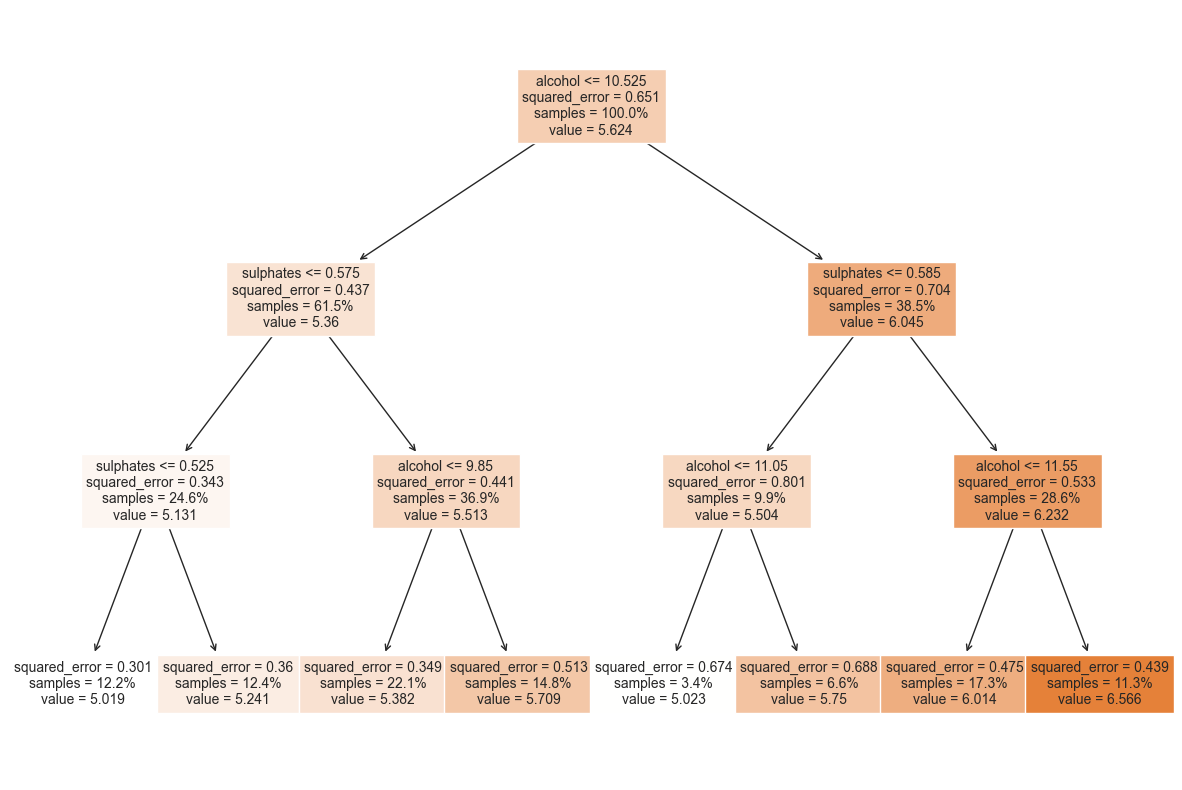

In [30]:
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

# proportion => sample as %
plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=['alcohol', 'sulphates'], filled=True, fontsize=10, proportion = True)
plt.show()

### Importancia de las variables
La importancia de las variables se deriva del propio modelo, y se calcula observando cómo cada característica contribuye a reducir la impureza (o aumentar la pureza) de los nodos en el árbol de decisión durante el proceso de entrenamiento.

In [31]:
X_train = train.drop('quality', axis=1)
y_train = train['quality']

# Gini criterio by default
classifier = DecisionTreeRegressor(random_state=42)
classifier.fit(X_train, y_train)

# Get importance
importances = classifier.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Exclude column 'index' if exists
if 'index' in feature_importance_df['Feature'].values:
    feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'index']

# Order by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Informe de Importancia de las Variables:")
print(feature_importance_df)


Informe de Importancia de las Variables:
                 Feature  Importance
11               alcohol    0.258506
10             sulphates    0.143047
2       volatile acidity    0.100915
7   total sulfur dioxide    0.073427
5              chlorides    0.070246
4         residual sugar    0.069785
6    free sulfur dioxide    0.054368
9                     pH    0.046554
8                density    0.045661
3            citric acid    0.041051
1          fixed acidity    0.038581


### Validación cruzada
 El objetivo es encontrar la mejor profundidad (best_depth) para un modelo de árbol de decisión utilizando la validación cruzada en series temporales y minimizando el Error Absoluto Medio (MAE). 

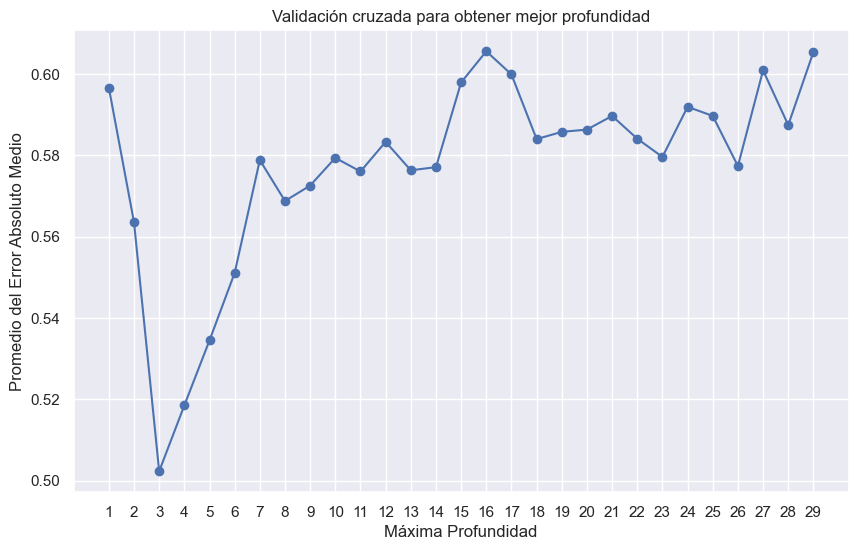

Mejor profundidad: 3
Menor Valor Absoluto Medio: 0.5022993553788051


In [32]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

train, test = train_test_split(df_wines[['alcohol', 'sulphates', 'quality']], test_size=0.3, random_state = 42)

# Reset index to maintain an order
train.reset_index(inplace = True)
test.reset_index(inplace = True)

cv = TimeSeriesSplit(n_splits = 4)

total_scores = []
best_depth = None

# Infinite float. For minimizing Mean Absolute Error.
# min_mae = float('inf') asegura que cualquier MAE encontrado en las primeras iteraciones del bucle 
# # será menor que min_mae, por lo que se actualizará. 
min_mae = float('inf')

# Trying with different depths
for i in range(1, 30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)

    for train_fold, test_fold in cv.split(train):
        
        # Divide train and test groups
        f_train = train.iloc[train_fold] # train_fold index, selects a row. F_train is a new df 
        f_test = train.iloc[test_fold] # test_fold index, selects a row. F_test is a new df
        
        # Train the model on the current fold
        dt.fit(
            X = f_train.drop(['quality'], axis = 1), # thorugh the column
            y = f_train['quality']
        )
        X_test = f_test.drop(['quality'], axis = 1) # thorugh the column
        y_pred = dt.predict(X_test)
        
        # Evaluation
        mae = mean_absolute_error(f_test['quality'], y_pred)
        fold_accuracy.append(mae)
    
    # Calculate and store the average accuracy for the current depth
    avg_mae = np.mean(fold_accuracy)
    total_scores.append(avg_mae)

    # Check if the current depth results in a lower MAE
    if avg_mae < min_mae:
        min_mae = avg_mae
        best_depth = i

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), total_scores, marker='o', linestyle='-', color='b')
plt.title('Validación cruzada para obtener mejor profundidad')
plt.xlabel('Máxima Profundidad')
plt.ylabel('Promedio del Error Absoluto Medio')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

# Print the results
print(f"Mejor profundidad: {best_depth}")
print(f"Menor Valor Absoluto Medio: {min_mae}")

### Ejecutar el modelo con el mejor parámetro, obtenido de la validación cruzada: la profundidad que da menor error, en este caso profundidad 3

Error absoluto medio: 0.56


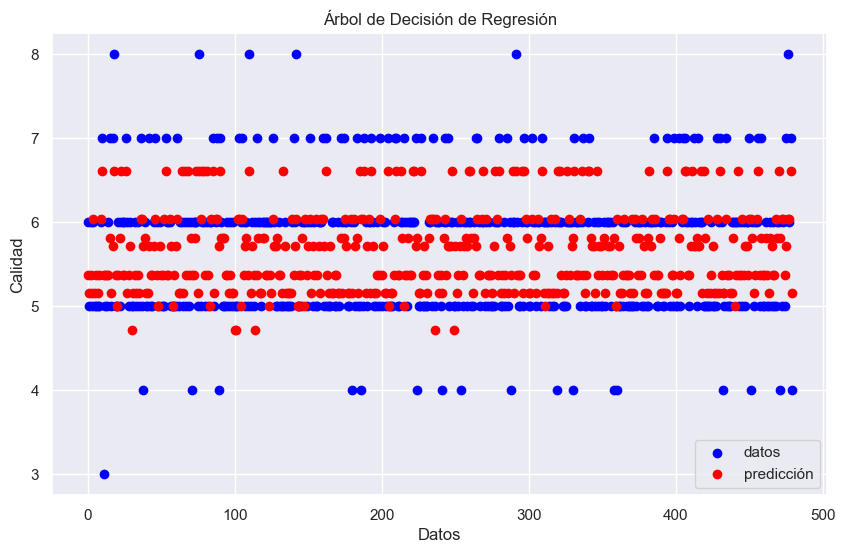

In [33]:
# Selecting classifier. Mean Squared Error by default
regressor = DecisionTreeRegressor(max_depth = 3)

# Training with all the group
regressor.fit(
    X = train.drop(['quality'], axis = 1),
    y = train['quality']
)

# Prediction 
y_pred = regressor.predict( X = test.drop(['quality'], axis = 1))

# Evaluation
mae = mean_absolute_error(test['quality'], y_pred)

print(f'Error absoluto medio: {round(mae, 2)}')

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(test.index, test['quality'], label='datos', color='blue')
plt.scatter(test.index, y_pred, label='predicción', color='red')
plt.title('Árbol de Decisión de Regresión')
plt.xlabel('Datos')
plt.ylabel('Calidad')
plt.legend()
plt.show()